#### Скачивание данных

In [1]:
!pip install vk
!pip install tqdm

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


Аккуратно скачаем все посты из группы.

* Используем tqdm для удобного вывода прогресса.
* На всякий случай запомним пост полностью, чтобы не скачивать все заного, если что-то потом "всплывет".
* Просмотры появились в постах не так давно, в старых их просто не будет. Предусмотрим это в коде.
* Вложений тоже может не быть, поэтому будем с ними аккуратнее.

In [1]:
import vk
import datetime
import pandas as pd
from tqdm import tqdm

session = vk.Session(access_token="38479e4a81d854219057927293934ed4d12b1c91afb966101385de82fc3d24310c0d5a039d4a907764504")
api = vk.API(session)

columns = ['text', 'views', 'likes', 'comments', 'is_ad', 'attachments', 'is_repost', 'time', 'raw']
df = pd.DataFrame(columns=columns)

result = api.wall.get(domain='tproger', count=1, v=5.103)
count = result['count']

for offset in tqdm(range(0, count, 100), position=0, leave=True):
    try:
        result = api.wall.get(domain='tproger', count=100, offset=offset, v=5.103)
        for post in result['items']:
            if "views" not in post:
                raise Exception("No views in post")
            """
            print('--- ' * 10)
            print("Пост №:", post['id'])
            print("Размер текста:", len(post['text']))
            print("Просмотры:", post['views']['count'])
            print("Лайки:", post['likes']['count'])
            print("Коменты:", post['comments']['count'])
            print("Реклама?", post['marked_as_ads'])
            print("Число вложений:", len(post['attachments']))
            print("Репост?", post.get('copy_history', None) != None)
            print("Время публикации:", post['date'])
            """
            attachments = post.get('attachments', [])

            df.loc[post['id']] = [
                post['text'],  post['views']['count'], post['likes']['count'], post['comments']['count'],
                post['marked_as_ads'], attachments, post.get('copy_history', None) != None, 
                post['date'], post
            ]
    except Exception as e:
        print("Error:", e)
        break
        


print(df.shape)
df.head()


 27%|██▋       | 67/244 [02:07<05:55,  2.01s/it]

Error: No views in post
(6798, 9)


,text,views,likes,comments,is_ad,attachments,is_repost,time,raw
1653786,Шарите в Java? Есть отличный шанс это продемон...,97431,460,166,0,"[{'type': 'photo', 'photo': {'id': 457676504, ...",False,1581689820,"{'id': 1653786, 'from_id': -30666517, 'owner_i..."
1656168,"M, A и T — уникальные цифры, причём MAM + MAT ...",20239,65,57,0,"[{'type': 'photo', 'photo': {'id': 457666888, ...",False,1583059620,"{'id': 1656168, 'from_id': -30666517, 'owner_i..."
1656033,Просто ламповое фото.\n\nЗа ламповость отвечае...,41305,290,135,0,"[{'type': 'photo', 'photo': {'id': 457675926, ...",False,1583043360,"{'id': 1656033, 'from_id': -30666517, 'owner_i..."
1655979,Хотите научиться программировать? Или изучить ...,40166,297,27,0,"[{'type': 'photo', 'photo': {'id': 457686360, ...",False,1582993140,"{'id': 1655979, 'from_id': -30666517, 'owner_i..."
1655966,Большая шпаргалка по нейросетям:\n\nЧасть 1: h...,48282,405,3,0,"[{'type': 'photo', 'photo': {'id': 457682157, ...",False,1582977960,"{'id': 1655966, 'from_id': -30666517, 'owner_i..."


#### Смотрим на данные и правим типы

Итак, мы скачали почти 7000 постов. Посмотрим на типы данных колонок.

In [2]:
for column in columns:
    print(f'{column}: {df[column].dtype}, {len(df[column])}')

text: object, 6798
views: object, 6798
likes: object, 6798
comments: object, 6798
is_ad: object, 6798
attachments: object, 6798
is_repost: object, 6798
time: object, 6798
raw: object, 6798


1) Во всех колонках одинаковое число записей, пропущенных значений нет. Иначе мы смогли бы использовать `dropna` или `fillna`, чтобы их заполнить.

2) У все колонок тип object (категориальные данные), хотя по факту в некоторых числа. Попробуем преобразовать тип.

In [3]:
num_columns = ['views', 'likes', 'comments', 'is_ad', 'is_repost', 'time']

for column in num_columns:
    df[column] = df[column].astype(int)

In [4]:
for column in columns:
    print(f'{column}: {df[column].dtype}, {len(df[column])}')

text: object, 6798
views: int64, 6798
likes: int64, 6798
comments: int64, 6798
is_ad: int64, 6798
attachments: object, 6798
is_repost: int64, 6798
time: int64, 6798
raw: object, 6798


Отлично, теперь в колонках числа, можем на них посмотреть.

In [5]:
df.describe()

,views,likes,comments,is_ad,is_repost,time
count,6798.000000,6798.000000,6798.000000,6798.000000,6798.000000,6.798000e+03
mean,45228.591645,263.829803,23.197705,0.115034,0.039865,1.527756e+09
std,18907.370042,307.198497,69.081790,0.319086,0.195656,2.939017e+07
min,14987.000000,2.000000,0.000000,0.000000,0.000000,1.483218e+09
25%,34261.250000,66.000000,5.000000,0.000000,0.000000,1.500835e+09
50%,41702.500000,158.000000,13.000000,0.000000,0.000000,1.528469e+09
75%,50034.250000,343.000000,26.000000,0.000000,0.000000,1.552314e+09
max,304023.000000,5044.000000,4560.000000,1.000000,1.000000,1.583060e+09


views


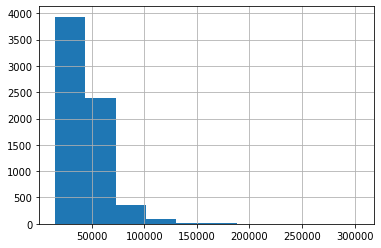

likes


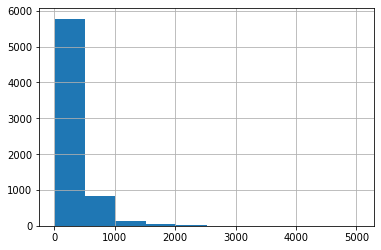

comments


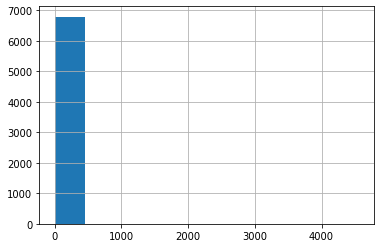

is_ad


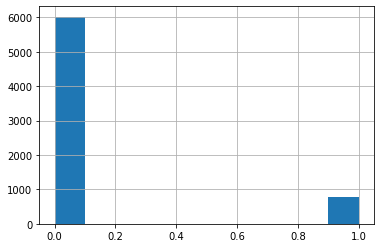

is_repost


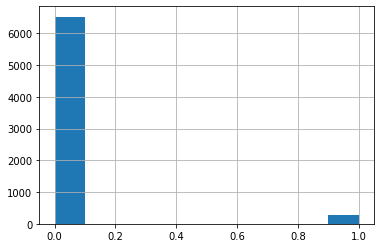

time


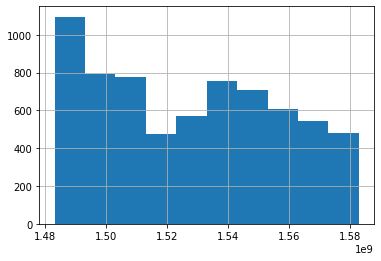

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline

num_columns = ['views', 'likes', 'comments', 'is_ad', 'is_repost', 'time']

for column in num_columns:
    print(column)
    df[column].hist()
    plt.show()

В данных выше мы можем увидеть интересные моменты: есть посты с аномально большим числом лайков и комментов. Можно на них посмотреть.

In [7]:
df.sort_values('comments', ascending=False)[:5]

,text,views,likes,comments,is_ad,attachments,is_repost,time,raw
1587910,В приложении «ВКонтакте» для Android появилась...,122638,312,4560,0,"[{'type': 'photo', 'photo': {'id': 456322633, ...",0,1555400095,"{'id': 1587910, 'from_id': -30666517, 'owner_i..."
1611436,Давайте устроим пятничный интерактив.\n\nВ ком...,83107,119,1936,0,"[{'type': 'photo', 'photo': {'id': 457405135, ...",0,1563542940,"{'id': 1611436, 'from_id': -30666517, 'owner_i..."
1579542,Сегодня в России прошли митинги против изоляци...,79485,492,596,0,"[{'type': 'photo', 'photo': {'id': 456277864, ...",0,1552245134,"{'id': 1579542, 'from_id': -30666517, 'owner_i..."
1624064,"Ностальгируем, не стесняемся",59649,180,576,0,"[{'type': 'photo', 'photo': {'id': 457486163, ...",0,1568370266,"{'id': 1624064, 'from_id': -30666517, 'owner_i..."
1645176,Что вас ждёт в Новом году? Предлагаем вам загл...,43828,37,538,0,"[{'type': 'photo', 'photo': {'id': 457635228, ...",0,1577714813,"{'id': 1645176, 'from_id': -30666517, 'owner_i..."


In [8]:
df.sort_values('likes', ascending=False)[:5]

,text,views,likes,comments,is_ad,attachments,is_repost,time,raw
1566145,,212569,5044,144,0,"[{'type': 'photo', 'photo': {'id': 456272768, ...",0,1546290005,"{'id': 1566145, 'from_id': -30666517, 'owner_i..."
1495237,Видеокурс «Основы программирования». \n \nРусс...,64540,4359,11,0,"[{'type': 'video', 'video': {'access_key': '76...",0,1500307628,"{'id': 1495237, 'from_id': -30666517, 'owner_i..."
1452322,"Year++, программисты!",135405,2972,127,0,"[{'type': 'photo', 'photo': {'id': 456240507, ...",0,1483218155,"{'id': 1452322, 'from_id': -30666517, 'owner_i..."
1483520,Подготовили для вас перевод подробного руковод...,96808,2925,17,0,"[{'type': 'link', 'link': {'url': 'https://tpr...",0,1493226250,"{'id': 1483520, 'from_id': -30666517, 'owner_i..."
1520134,"Привет. Просто анимированная форма логина, зац...",76559,2661,66,0,"[{'type': 'doc', 'doc': {'id': 460704137, 'own...",0,1519661280,"{'id': 1520134, 'from_id': -30666517, 'owner_i..."


#### Feature Engineering и предварительная обработка

Визуально мы заметили, что некоторые посты отмечены хэш-тегом "\#партнерский". Попробуем найти такие посты и посмотреть, отмечены ли они как реклама.

Для это применим функцию к столбцу text и получим новый столбец.

In [9]:
def is_partner(text):
    if "#партнерский" in text.replace('ё', 'е').lower():
        return 1
    else:
        return 0
    
# df['is_partner'] = df['text'].apply(is_partner)

In [24]:
df['time']

1653786    1581689820
1656168    1583059620
1656033    1583043360
1655979    1582993140
1655966    1582977960
              ...    
1452548    1483268513
1452510    1483259464
1452492    1483250489
1452409    1483225265
1452322    1483218155
Name: time, Length: 6798, dtype: int64

In [56]:
# additional column that keeps bool
def is_holiday(unix_time):
    dates= ['0125', '0401', '0412', '0524', '0601', '0708', '0822', '0901', '1005', '1212']
    
    date = datetime.datetime.fromtimestamp(unix_time)
    d = str(date.date())
    if d[5:10].replace('-', '') in dates:
        return True
    else:
        return False

df['is_holiday'] = df['time'].apply(is_holiday)

In [10]:
df = df.drop(columns=['is_repost'])

Интересно, а все ли посты, отмеченные, как партнерские, помечены, как реклама.

Оказывается, нет! Выходит, мы только что придумали, как достать новую информацию из уже имеющихся данных. Это называется **feature ingineerring**. Именно в этом и состоит *искусство* машинного обучения.

https://habr.com/ru/company/mlclass/blog/248129/

Еще у нас есть время публикации. Попробуем достать из него, например, день недели.

https://stackoverflow.com/questions/9847213/how-do-i-get-the-day-of-week-given-a-date

In [12]:
from datetime import date
import calendar

# test
print("Today:", calendar.day_name[datetime.datetime.today().weekday()])


def get_weekday(unix_time):
    date = datetime.datetime.fromtimestamp(unix_time)
    return calendar.day_name[date.weekday()]


df['weekday'] = df['time'].apply(get_weekday)   

Today: Sunday


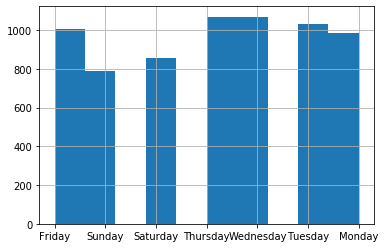

In [13]:
df['weekday'].hist()

Как отправить эти данные в машину? Превратить в числа. Первое что приходит в голову - просто выдать номер для каждого для недели.

Но тогда получится, что воскренье больше понедельника, что не так - они идут подряд, а это может сбить некоторые модели с толку. Поэтому вместо этого создадим по булевому признаку для каждого дня недели.

In [57]:
df = pd.concat([df, pd.get_dummies(df['weekday'], prefix='is_')] , axis=1)

In [58]:
df.head()

,text,views,likes,comments,is_ad,attachments,time,raw,weekday,is_holiday,is__Friday,is__Monday,is__Saturday,is__Sunday,is__Thursday,is__Tuesday,is__Wednesday
1653786,Шарите в Java? Есть отличный шанс это продемон...,97431,460,166,0,"[{'type': 'photo', 'photo': {'id': 457676504, ...",1581689820,"{'id': 1653786, 'from_id': -30666517, 'owner_i...",Friday,False,1,0,0,0,0,0,0
1656168,"M, A и T — уникальные цифры, причём MAM + MAT ...",20239,65,57,0,"[{'type': 'photo', 'photo': {'id': 457666888, ...",1583059620,"{'id': 1656168, 'from_id': -30666517, 'owner_i...",Sunday,False,0,0,0,1,0,0,0
1656033,Просто ламповое фото.\n\nЗа ламповость отвечае...,41305,290,135,0,"[{'type': 'photo', 'photo': {'id': 457675926, ...",1583043360,"{'id': 1656033, 'from_id': -30666517, 'owner_i...",Sunday,False,0,0,0,1,0,0,0
1655979,Хотите научиться программировать? Или изучить ...,40166,297,27,0,"[{'type': 'photo', 'photo': {'id': 457686360, ...",1582993140,"{'id': 1655979, 'from_id': -30666517, 'owner_i...",Saturday,False,0,0,1,0,0,0,0
1655966,Большая шпаргалка по нейросетям:\n\nЧасть 1: h...,48282,405,3,0,"[{'type': 'photo', 'photo': {'id': 457682157, ...",1582977960,"{'id': 1655966, 'from_id': -30666517, 'owner_i...",Saturday,False,0,0,1,0,0,0,0


Сделаем еще пару признаков - длина текста и количество вложений.

In [59]:
df['attachments_len'] = df['attachments'].apply(lambda x:len(x))
df['text_len'] = df['text'].apply(lambda x:len(x))

#### Убираем аутлайнеров

Как мы видели ранее, в наших данных есть очень нетипичные почты, которые сильно отличаются от остальных. Например, пост про новый год, у которого очень много лайков.

Если мы хотим сделать модель с более высокой обобщающей способностью, такие данные полезно отбросить. Например, можно посмотреть на стандартное отклонение и отбросить все, что лежит сильно дальше среднего.

Однако, становится ли от этого лучше, стоит отдельно проверить позже.

In [60]:
learn_df = df.drop(columns=['text', 'attachments', 'raw', 'weekday'])

In [61]:
def not_outliner(value, mean_value, std_value):
    if mean_value - 3 * std_value < value < mean_value + 3 * std_value:
        return True
    return False

for column in learn_df.columns:
    mean_value = df[column].mean()
    std_value = df[column].std()
    regular_posts = learn_df[column].apply(lambda x: not_outliner(x, mean_value, std_value))
    learn_df = learn_df[regular_posts]

print(df.shape)
print(learn_df.shape)

(6798, 19)
(6004, 15)


#### Обучаем модели

In [62]:
X = learn_df.drop(columns=['views'])
Y = learn_df['views']

In [63]:
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, random_state=42)

In [64]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(X_train)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [65]:
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error

models = {
    "linear": LinearRegression(),
    "linear with regularisation": Ridge(),
    "tree": DecisionTreeRegressor(max_depth=5),
    "forest": RandomForestRegressor(),
    "gradient_boosting": GradientBoostingRegressor()
}

for model_name in models:
    models[model_name].fit(X_train, Y_train)
    train_predictions = models[model_name].predict(X_train)
    test_predictions = models[model_name].predict(X_test)
    
    print("")
    print("Model: ", model_name)
    print("Train MSE:", mean_squared_error(Y_train, train_predictions) ** 0.5)
    print("Test MSE:", mean_squared_error(Y_test, test_predictions) ** 0.5)


Model:  linear
Train MSE: 9724.84398370423
Test MSE: 10026.954927538714

Model:  linear with regularisation
Train MSE: 9714.555624588738
Test MSE: 10041.03557760566

Model:  tree
Train MSE: 8341.110676840515
Test MSE: 8961.509776365338

Model:  forest
Train MSE: 2865.1252994606352
Test MSE: 7864.599423155876

Model:  gradient_boosting
Train MSE: 6957.456858029286
Test MSE: 8015.296134605257


На данный момент лучше всего работает случайный лес и градиентный бустинг. Можно посмотреть, на какие признаки он опирается.

In [66]:
for (w, n) in sorted(zip(models["forest"].feature_importances_, X.columns)):
    print(n, " - ", w)

is_holiday  -  0.0
is__Monday  -  0.004660018137949534
is__Saturday  -  0.005362938476817691
is__Tuesday  -  0.005399467366174182
is__Friday  -  0.005400410005946114
is__Wednesday  -  0.006468356790836421
is__Thursday  -  0.006612078434968855
is_ad  -  0.007397868135261241
is__Sunday  -  0.009231805531561369
attachments_len  -  0.05195949963548202
comments  -  0.0629802412776922
text_len  -  0.08079102776479406
time  -  0.22326483410029954
likes  -  0.5304714543422169


Чтобы посмотреть, влияют ли признаки негативно или положительно можем дополнительно посмотреть на регрессию.

In [67]:
for (w, n) in sorted(zip(models["linear"].coef_, X.columns)):
    print(n, " - ", w)

is_holiday  -  -7.909341444822358e+16
time  -  -668.0859921215165
attachments_len  -  -524.8537810515625
text_len  -  1057.1420127047986
is_ad  -  1085.9872077716745
comments  -  2239.017220077638
likes  -  8651.073458102295
is__Sunday  -  2.5969560756947136e+17
is__Saturday  -  2.6707879116402022e+17
is__Friday  -  2.8158895608703664e+17
is__Monday  -  2.8816118409131946e+17
is__Thursday  -  2.9512504928959155e+17
is__Tuesday  -  2.951250492895919e+17
is__Wednesday  -  2.959716767437318e+17


Выходит, что лучше всего публиковать посты в воскресенье, а хуже всего в среду. Много вложений - это плохо.